# Importing required packages

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cd /content/drive/MyDrive/ASL_classification

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Preparing dataset

In [129]:
data = np.load('/content/drive/MyDrive/ASL_classification/Data/X_10classes.npy') 
labels = np.load('/content/drive/MyDrive/ASL_classification/Data/y_10classes.npy')

In [130]:
print("dimensions of dataset:",data.shape)
print("dimensions of labels:",labels.shape)

values,counts = np.unique(labels, return_counts=True)
print("all the unique labels of dataset:",values)
print("freq of each unique label",counts)

dimensions of dataset: (20843, 42)
dimensions of labels: (20843,)
all the unique labels of dataset: [0 1 2 3 4 5 6 7 8 9]
freq of each unique label [1896 2045 1933 2421 2019 2254 2503 1890 1943 1939]


In [131]:
#encoding to one-hot format
one_hot_labels = np.zeros((labels.size,max(labels)+1)) 
for i in range(labels.shape[0]):
  one_hot_labels[i,labels[i]] = 1

In [132]:
#shuffle and split the dataset
indices = np.random.permutation(data.shape[0])
train_idx , valid_idx , test_idx = indices[0:int(len(data)*0.6)] , indices[int(len(data)*0.6):int(len(data)*0.8)], indices[int(len(data)*0.8):]
train_data = data[train_idx,:]
train_labels = one_hot_labels[train_idx,:]
valid_data = data[valid_idx,:]
valid_labels = one_hot_labels[valid_idx,:]
test_data = data[test_idx,:]
test_labels = one_hot_labels[test_idx,:]

In [133]:
#dataset experiments
print('dimension of train data:',train_data.shape)
print('dimension of train labels:',train_labels.shape)
print('dimension of validation data:',valid_data.shape)
print('dimension of validation labels:',valid_labels.shape)
print('dimension of test data:',test_data.shape)
print('dimension of test labels:',test_labels.shape)

dimension of train data: (12505, 42)
dimension of train labels: (12505, 10)
dimension of validation data: (4169, 42)
dimension of validation labels: (4169, 10)
dimension of test data: (4169, 42)
dimension of test labels: (4169, 10)


# Feedforward functions


In [103]:
def linear_layer(X,W,b):
  z = np.dot(X,W) + b
  return z

def ReLU(x):
  a = np.max(x,0)
  return a

def sigmoid(x):
  a = 1/(1+np.exp(-x))
  return a

def softmax(x):
  temp = np.sum(np.exp(x), axis=1)
  temp = temp[...,np.newaxis] #i did this for removing the broadcasting error
  a = np.exp(x) / temp #dar rastaye satr jam mikonad
  return a

In [104]:
def feedforward(X,parameters):

  global neuron_values
  neuron_values['linear'+str(0)] = X
  neuron_values['activation'+str(0)] = X

  for i in range(1,len(layers)):
    A_previous = X

    X = linear_layer(A_previous,parameters['w'+str(i)],parameters['b'+str(i)]) #dar khuruji har satr baraye yek data ast
    neuron_values['linear'+str(i)] = X
    

    if (activations[i]=='sigmoid'):
      X = sigmoid(X)
      neuron_values['activation'+str(i)] = X

    elif (activations[i]=='softmax'):
      X = softmax(X)
      neuron_values['activation'+str(i)] = X

    else:
      pass

  return X

# Computing cost

In [105]:
def compute_cost(y,label): #you should change this function - mse is not a good choice!


  m = y.shape[0]
  loss = -1/m * (np.dot(label,np.log(y).T))

  return loss


# Backward functions

In [106]:
def compute_derivative(activation_cache, activation):
  z = activation_cache

  if activation == 'softmax':
    dz = z * (1-z)

  elif activation == 'sigmoid':
    dz = z * (1-z)
    
  elif activation == 'ReLU':
    dz[z<0] = 0
  
  return dz

In [107]:
def backward(loss):
  
  L = len(layers)-1 #number of layers
  grads = {}
  delta = {}
  
  for i in range(L,0,-1):
    linear_cache = neuron_values['linear'+str(i)]
    activation_cache = neuron_values['activation'+str(i)]

    if i == L: #we are in the last layer
      dz = compute_derivative(activation_cache,activations[i])
      delta[i] = dz * loss
      y = neuron_values['activation'+str(i-1)] #previous layer
      grads['dw'+str(i)] = learning_rate * np.dot(y.T,delta[i])
      grads['db'+str(i)] = learning_rate * np.dot(y.T,delta[i])

    else: 
      dz = compute_derivative(activation_cache,activations[i])
      delta[i] = dz * (np.dot(delta[i+1],parameters['w'+str(i+1)].T))
      y = neuron_values['activation'+str(i-1)] #previous layer
      grads['dw'+str(i)] = learning_rate * np.dot(y.T,delta[i])
      grads['db'+str(i)] = learning_rate * np.dot(y.T,delta[i])

  return grads

# Training

In [108]:
def initialize_parameters(layer_dims):
  #each of the elements in layer_dims shows the number of neurons in it
  parameters = {}
  for l in range(1,len(layer_dims)):
    parameters['w'+str(l)] = np.random.randn(layer_dims[l-1],layer_dims[l]) * 0.1
    parameters['b'+str(l)] = np.zeros((1,layer_dims[l]))
  return parameters

In [142]:
layers = [42,100,10]
neuron_values = {}
activations = ['None','sigmoid','softmax']
epoch = 15
learning_rate = 0.1
parameters = initialize_parameters(layers)
#print(parameters['w1'].shape)
#print(parameters['w2'].shape)

#w1 will have the shape of 42x200
#w2 will have the shape of 200x10

In [143]:
import time

train_loss_per_epoch = []
valid_loss_per_epoch = []
train_accuracy_per_epoch = []
valid_accuracy_per_epoch = []

tstart = time.time()
for i in range(epoch):

  train_losses = 0
  valid_losses = 0
  TP_train = 0
  TP_valid = 0

  #iterating over training dataset
  for j in range(train_data.shape[0]): 
    sample = train_data[j,:] #shape=(42,)
    label = train_labels[j,:]#shape (10,)

    sample = sample[np.newaxis,...] #shape=(1,42)
    label = label[np.newaxis,...] #shape=(10,1)

    output = feedforward(sample,parameters)
    loss = compute_cost(output,label)

    error = label - output
    grads = backward(error)
    
    #calculating number of true positives
    label = np.argmax(label) 
    predicted = np.argmax(output)
    if label==predicted:
      TP_train += 1

    #updating weight values
    for k in range(1,len(layers)):
     parameters['w'+str(k)] = parameters['w'+str(k)] + grads['dw'+str(k)]


    loss = np.sum(loss)
    train_losses += loss

  #iterating over validation dataset
  for j in range(valid_data.shape[0]): 
    sample = valid_data[j,:] #shape=(42,)
    label = valid_labels[j,:] #shape (10,)

    sample = sample[np.newaxis,...] #shape=(1,42)
    label = label[np.newaxis,...] #shape=(10,1)

    output = feedforward(sample,parameters)
    loss = compute_cost(output,label)

    #calculating number of true positives
    label = np.argmax(label) 
    predicted = np.argmax(output)
    if label==predicted:
      TP_valid += 1

    loss = np.sum(loss)
    valid_losses += loss

  train_loss_per_epoch.append(train_losses)
  valid_loss_per_epoch.append(valid_losses)
  train_accuracy_per_epoch.append(TP_train/train_data.shape[0])
  valid_accuracy_per_epoch.append(TP_valid/valid_data.shape[0])
  print('**** end of epoch',i,'***')
tend = time.time()

print('total time:',tend-tstart)

**** end of epoch 0 ***
**** end of epoch 1 ***
**** end of epoch 2 ***
**** end of epoch 3 ***
**** end of epoch 4 ***
**** end of epoch 5 ***
**** end of epoch 6 ***
**** end of epoch 7 ***
**** end of epoch 8 ***
**** end of epoch 9 ***
**** end of epoch 10 ***
**** end of epoch 11 ***
**** end of epoch 12 ***
**** end of epoch 13 ***
**** end of epoch 14 ***
total time: 25.169409036636353


#Plots

train loss at last epoch: 916.988868037973
validation loss at last epoch: 341.3174058646667


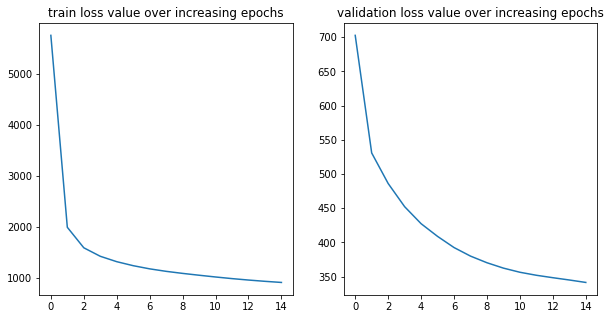

In [145]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
plt.title('train loss value over increasing epochs')
plt.plot(train_loss_per_epoch)

ax2 = plt.subplot(122)
plt.title('validation loss value over increasing epochs')
plt.plot(valid_loss_per_epoch)

print('train loss at last epoch:',train_loss_per_epoch[-1])
print('validation loss at last epoch:',valid_loss_per_epoch[-1])

train accuracy at last epoch: 0.9829668132746902
validation accuracy at last epoch: 0.9796114176061406


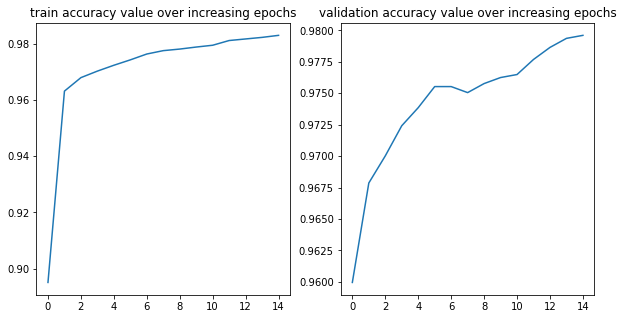

In [146]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
plt.title('train accuracy value over increasing epochs')
plt.plot(train_accuracy_per_epoch)

ax2 = plt.subplot(122)
plt.title('validation accuracy value over increasing epochs')
plt.plot(valid_accuracy_per_epoch)

print('train accuracy at last epoch:',train_accuracy_per_epoch[-1])
print('validation accuracy at last epoch:',valid_accuracy_per_epoch[-1])

In [ ]:
plt.plot(valid_loss_per_epoch)

# Generating output

In [ ]:
number = 200
sample = test_data[number]
label = test_labels[number]
classes = ['A','B','C','D','E','F','G','H','I','J']
output = feedforward(sample,parameters)
print('desired outpur:',classes[np.argmax(label)])
print('predicted outpur:',classes[np.argmax(output)])

desired outpur: J
predicted outpur: J


# Results

In [147]:
#confusion matirx
confusion_matrix = np.zeros((10,10))
loss = 0
TP = 0

for i in range(test_data.shape[0]):
  sample = test_data[i,:] #shape=(42,)
  label = test_labels[i,:] #shape (10,)

  sample = sample[np.newaxis,...] #shape=(1,42)
  label = label[np.newaxis,...] #shape=(10,1)

  output = feedforward(sample,parameters)
  loss += compute_cost(output,label)
  
  label = np.argmax(label)
  predicted = np.argmax(output)
  if label==predicted:
    TP += 1

  confusion_matrix[label][predicted] +=1


print('test loss:',loss)
print('test accuracy:',TP/test_data.shape[0])
print('test error:', 1 - TP/test_data.shape[0])



test loss: [[411.40073098]]
test accuracy: 0.9767330295034781
test error: 0.023266970496521933


In [149]:
print('confusion matrix:')
print('the row indexes are output labels and column labels depict actual outputs')
print(confusion_matrix)

row_sum = np.sum(confusion_matrix,axis=1)
col_sum = np.sum(confusion_matrix,axis=0)
tp = confusion_matrix.diagonal()

print('precision for each class:',tp/(row_sum+1))
print('recall for each class:',tp/(col_sum+1))

precision = np.sum(tp/(row_sum+1)) / len(tp) #+1 ezafe shode ast ta az taghsim bar 0 jelogiri shavad
recall = np.sum(tp/(col_sum+1)) / len(tp) #+1 ezafe shode ast ta az taghsim bar 0 jelogiri shavad
F1 = (2*precision*recall) / (precision + recall)


print('F1 score',F1)

confusion matrix:
the row indexes are output labels and column labels depict actual outputs
[[392.   3.   1.   1.   0.   0.   3.   1.   1.   0.]
 [  1. 417.   5.   2.   0.   0.   0.   0.   0.   2.]
 [  0.   1. 350.   0.   0.   0.   0.   0.   0.   0.]
 [  3.   2.   1. 492.   2.   0.   0.   0.   0.   0.]
 [  0.   2.   0.   0. 374.   3.   0.   0.   1.   0.]
 [  0.   0.   1.   0.   5. 455.   0.   1.   1.   0.]
 [  4.   1.   0.   1.   0.   0. 455.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0. 354.   0.   1.]
 [  1.   1.   0.   1.   1.   3.   0.   0. 382.   7.]
 [  3.   5.   0.   3.   0.   0.   1.   0.  21. 401.]]
precision for each class: [0.97270471 0.97429907 0.99431818 0.98203593 0.9816273  0.98060345
 0.98484848 0.99438202 0.96221662 0.92183908]
recall for each class: [0.96790123 0.9630485  0.97493036 0.98203593 0.97650131 0.98484848
 0.98913043 0.99159664 0.93857494 0.97330097]
F1 score 0.9745370562941096


In [151]:
np.save('weights.npy',parameters) #saving the model

In [152]:
import pickle

with open('parameters.pickle', 'wb') as handle:
    pickle.dump(parameters, handle)